In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('all_locations.csv')

In [3]:
df['pv_measurement'].fillna(method='ffill', inplace=True)

In [4]:
split_date = '2022-10-27'

# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])
df = pd.get_dummies(df, columns=['location'])

# Sorting the data by the 'time' column to maintain chronological order
df.sort_values('time', inplace=True)

# Splitting the data into training and test sets based on the split date
train_df = df[df['time'] < split_date]
test_df = df[df['time'] >= split_date]

# Identifying the features and the target variable
X_train = train_df.drop(columns=['pv_measurement', 'time'])  # Assuming all other columns are features
y_train = train_df['pv_measurement']
X_test = test_df.drop(columns=['pv_measurement', 'time'])
y_test = test_df['pv_measurement']

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)
# Calculate MAE on the test set
mae = mean_absolute_error(y_test, y_pred)
mae

150.60847956673135

C:\Users\marku\AppData\Local\Temp\ipykernel_16636\2663723213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predictions'] = y_pred
C:\Users\marku\AppData\Local\Temp\ipykernel_16636\2663723213.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['original_location'] = test_df.apply(restore_location, axis=1)


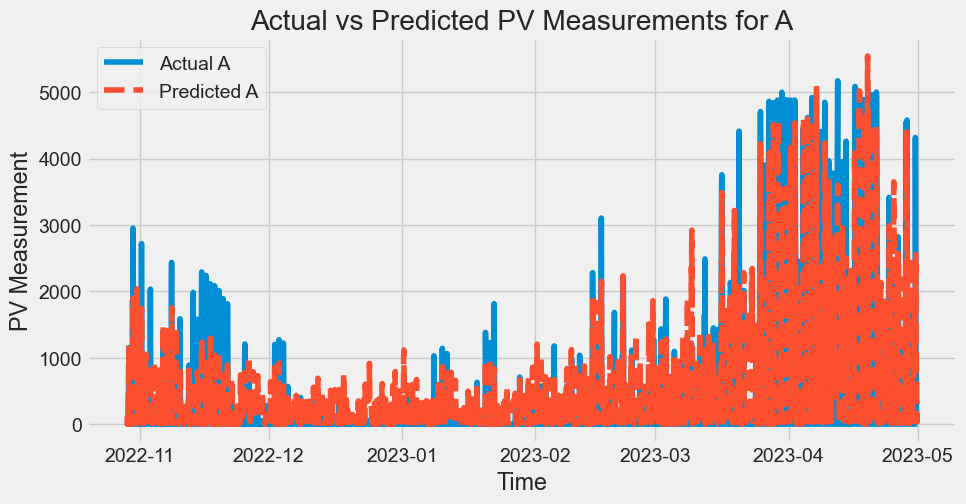

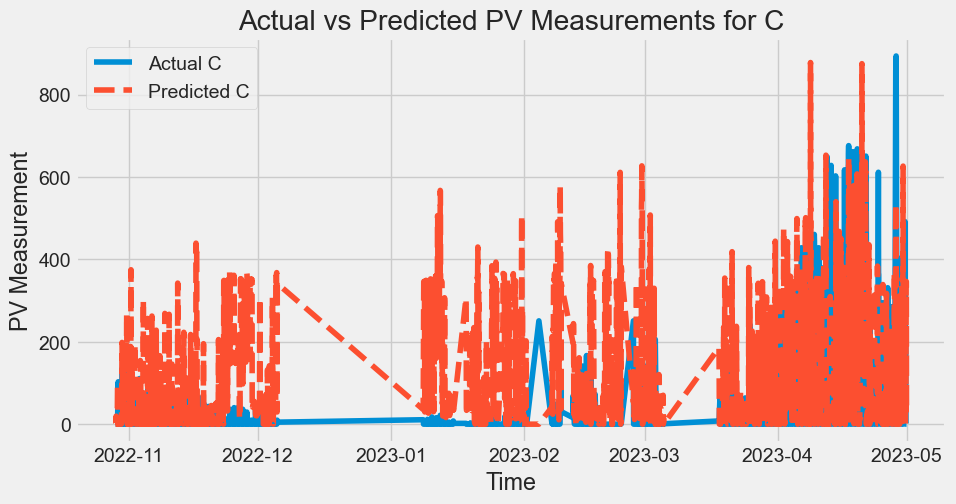

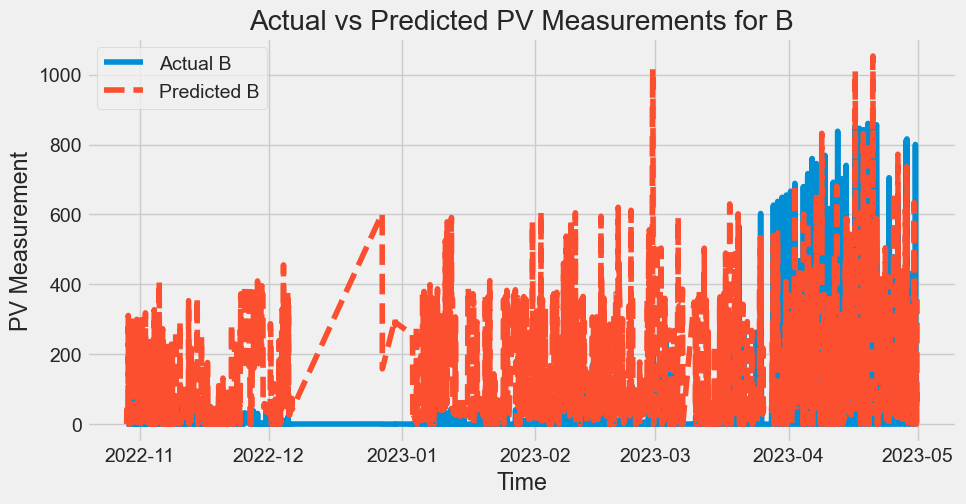

In [5]:
# Step 1: Add predictions to the test DataFrame
test_df['predictions'] = y_pred

# Step 2: Restore original 'location' column
def restore_location(row):
    for loc in ['location_A', 'location_B', 'location_C']:  # Adjust this list based on your actual column names
        if row[loc] == 1:
            return loc.replace('location_', '')
    return None

test_df['original_location'] = test_df.apply(restore_location, axis=1)

# Step 3: Plotting individual series
unique_locations = test_df['original_location'].unique()

for loc in unique_locations:
    subset = test_df[test_df['original_location'] == loc]

    plt.figure(figsize=(10, 5))
    plt.plot(subset['time'], subset['pv_measurement'], label=f'Actual {loc}')
    plt.plot(subset['time'], subset['predictions'], label=f'Predicted {loc}', linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title(f'Actual vs Predicted PV Measurements for {loc}')
    plt.legend()
    plt.show()

In [6]:
def date_features(df):
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.dayofyear
    df['month'] = pd.to_datetime(df['time']).dt.month
    df['quarter'] = pd.to_datetime(df['time']).dt.quarter
    return df

df = date_features(df)